## Implementing DeepDream in Keras

450560/440742 [==============================] - 4s 10us/step


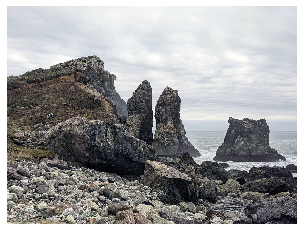

In [2]:
from tensorflow import keras
import matplotlib.pyplot as plt

base_image_path = keras.utils.get_file("coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg")
plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

In [3]:
from tensorflow.keras.applications import inception_v3
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

87924736/87910968 [==============================] - 12s 0us/step


In [4]:
layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
    }

outputs_dict = dict([(layer.name, layer.output)
                     for layer in [model.get_layer(name)
                                   for name in layer_settings.keys()]
                     ])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [5]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    return loss

In [6]:
import tensorflow as tf
@tf.function
def gradient_ascent_step(image, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return loss, image

In [7]:
def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print(f"... Loss value at step {i}: {loss:.2f}")
    return image

In [8]:
step = 20.
num_octave = 3
octave_scale = 1.4
iterations = 30
max_loss = 15.

In [9]:
import numpy as np

def preprocess_image(image_path):
    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img /= 2.0
    img += 0.5
    img *= 255.
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [10]:
# Running gradient ascent over multiple successive "octaves"

original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]
successive_shapes = [original_shape]

for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
    successive_shapes = successive_shapes[::-1]
    
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
    print(f"Processing octave {i} with shape {shape}")
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(img, iterations=iterations, learning_rate=step, max_loss=max_loss)
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)
keras.utils.save_img("dream.png", deprocess_image(img.numpy()))

Processing octave 0 with shape (459, 612)
... Loss value at step 0: 0.80
... Loss value at step 1: 1.07
... Loss value at step 2: 1.44
... Loss value at step 3: 1.82
... Loss value at step 4: 2.16
... Loss value at step 5: 2.50
... Loss value at step 6: 2.85
... Loss value at step 7: 3.18
... Loss value at step 8: 3.55
... Loss value at step 9: 3.89
... Loss value at step 10: 4.24
... Loss value at step 11: 4.61
... Loss value at step 12: 4.95
... Loss value at step 13: 5.31
... Loss value at step 14: 5.62
... Loss value at step 15: 6.00
... Loss value at step 16: 6.35
... Loss value at step 17: 6.71
... Loss value at step 18: 7.04
... Loss value at step 19: 7.33
... Loss value at step 20: 7.70
... Loss value at step 21: 8.00
... Loss value at step 22: 8.34
... Loss value at step 23: 8.58
... Loss value at step 24: 8.90
... Loss value at step 25: 9.14
... Loss value at step 26: 9.44
... Loss value at step 27: 9.74
... Loss value at step 28: 9.95
... Loss value at step 29: 10.20
Process

## Neural style transfer

Neural style transfer can be implemented using any pretrained convnet. Here, we’ll use the VGG19 network used by Gatys et al. VGG19 is a simple variant of the VGG16 network introduced in chapter 5, with three more convolutional layers.

Here’s the general process:
- Set up a network that computes VGG19 layer activations for the style-reference image, the base image, and the generated image at the same time.
- Use the layer activations computed over these three images to define the loss function described earlier, which we’ll minimize in order to achieve style transfer.
- Set up a gradient-descent process to minimize this loss function.

Let’s start by defining the paths to the style-reference image and the base image. To make sure that the processed images are a similar size (widely different sizes make style transfer more difficult), we’ll later resize them all to a shared height of 400 px.

In [11]:
base_image_path = keras.utils.get_file("sf.jpg", origin="https://img-datasets.s3.amazonaws.com/sf.jpg")
style_reference_image_path = keras.utils.get_file("starry_night.jpg", origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")

original_width, original_height = keras.utils.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

958464/943128 [==============================] - 3s 3us/step


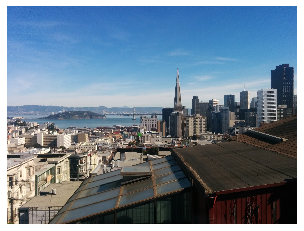

In [12]:
plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

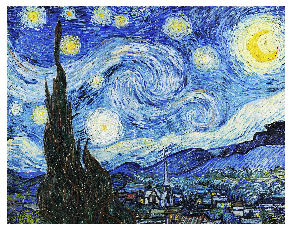

In [14]:
plt.axis("off")
plt.imshow(keras.utils.load_img(style_reference_image_path))

In [15]:
def preprocess_image(image_path):
    img = keras.utils.load_img(image_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

In [16]:
def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [18]:
# Using a pretrained VGG19 model to create a feature extractor

model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80150528/80134624 [==============================] - 9s 0us/step


In [19]:
# Content loss
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))

In [20]:
# Style loss

def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

To these two loss components, you add a third: the total variation loss, which operates on the pixels of the generated combination image. It encourages spatial continuity in
the generated image, thus avoiding overly pixelated results. You can interpret it as a regularization loss.

In [21]:
def total_variation_loss(x):
    a = tf.square(x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :])
    b = tf.square(x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [22]:
# Defining the final loss that you’ll minimize

style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
    ]
content_layer_name = "block5_conv2"

total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(    [base_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss += content_weight * content_loss(base_image_features, combination_features)
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [23]:
# Setting up the gradient-descent process

import tensorflow as tf
@tf.function
def compute_loss_and_grads(
    combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96)
)

In [24]:
base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image)
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        keras.utils.save_img(fname, img)

Iteration 100: loss=8136.94
Iteration 200: loss=6651.92
Iteration 300: loss=6062.70
Iteration 400: loss=5742.22
Iteration 500: loss=5536.09
Iteration 600: loss=5390.39
Iteration 700: loss=5280.69
Iteration 800: loss=5195.05
Iteration 900: loss=5126.03
Iteration 1000: loss=5069.05
Iteration 1100: loss=5021.22
Iteration 1200: loss=4980.26
Iteration 1300: loss=4944.87
Iteration 1400: loss=4913.99
Iteration 1500: loss=4886.85
Iteration 1600: loss=4862.85
Iteration 1700: loss=4841.44
Iteration 1800: loss=4822.12
Iteration 1900: loss=4804.66
Iteration 2000: loss=4788.84
Iteration 2100: loss=4774.44
Iteration 2200: loss=4761.28
Iteration 2300: loss=4749.20
Iteration 2400: loss=4738.08
Iteration 2500: loss=4727.81
Iteration 2600: loss=4718.29
Iteration 2700: loss=4709.47
Iteration 2800: loss=4701.30
Iteration 2900: loss=4693.70
Iteration 3000: loss=4686.61
Iteration 3100: loss=4679.98
Iteration 3200: loss=4673.78
Iteration 3300: loss=4667.96
Iteration 3400: loss=4662.51
Iteration 3500: loss=46

##  Generating images with variational autoencoders

VAE encoder network

In [25]:
from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

Latent-space-sampling layer

In [26]:
import tensorflow as tf
class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

VAE decoder network, mapping latent space points to images

In [27]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

VAE model with custom train_step()

In [28]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
        name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
    
    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(
                keras.losses.binary_crossentropy(data, reconstruction),
                axis=(1, 2))
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)
            return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
}

In [29]:
import numpy as np
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 89s 163ms/step - total_loss: 208.9759 - reconstruction_loss: 206.6531 - kl_loss: 2.3229
Epoch 2/30
547/547 [==============================] - 85s 155ms/step - total_loss: 185.9807 - reconstruction_loss: 183.7185 - kl_loss: 2.2623
Epoch 3/30
547/547 [==============================] - 84s 153ms/step - total_loss: 181.0578 - reconstruction_loss: 178.6602 - kl_loss: 2.3974
Epoch 4/30
547/547 [==============================] - 85s 155ms/step - total_loss: 166.1020 - reconstruction_loss: 162.5215 - kl_loss: 3.5805
Epoch 5/30
547/547 [==============================] - 83s 151ms/step - total_loss: 158.5408 - reconstruction_loss: 154.6499 - kl_loss: 3.8909
Epoch 6/30
547/547 [==============================] - 83s 151ms/step - total_loss: 156.0749 - reconstruction_loss: 152.1692 - kl_loss: 3.9058
Epoch 7/30
547/547 [==============================] - 83s 151ms/step - total_loss: 154.5097 - reconstruction_loss: 150.6226 - kl_loss: 3.8870
Epoch 

In [ ]:
# Sampling a grid of images from the 2D latent space

import matplotlib.pyplot as plt

n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size : (i + 1) * digit_size,
               j * digit_size : (j + 1) * digit_size,
        ] = digit
        
plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")



## GAN

Schematically, the GAN looks like this:

- A generator network maps vectors of shape (latent_dim,) to images of shape (64, 64, 3).
- A discriminator network maps images of shape (64, 64, 3) to a binary score estimating the probability that the image is real.
- A gan network chains the generator and the discriminator together: gan(x) = discriminator(generator(x)). Thus, this gan network maps latent space vectors to the discriminator’s assessment of the realism of these latent vectors as decoded by the generator.
- We train the discriminator using examples of real and fake images along with “real”/“fake” labels, just as we train any regular image-classification model.
- To train the generator, we use the gradients of the generator’s weights with regard to the loss of the gan model. This means that at every step, we move the weights of the generator in a direction that makes the discriminator more likely to classify as “real” the images decoded by the generator. In other words, we train the generator to fool the discriminator.

Here are a few of the tricks used in the implementation of the GAN generator and discriminator in this section. It isn’t an exhaustive list of GAN-related tips; you’ll find many more across the GAN literature:
-  We use strides instead of pooling for downsampling feature maps in the discriminator, just like we did in our VAE encoder.
-  We sample points from the latent space using a normal distribution (Gaussian distribution), not a uniform distribution.
-  Stochasticity is good for inducing robustness. Because GAN training results in a dynamic equilibrium, GANs are likely to get stuck in all sorts of ways. Introducing randomness during training helps prevent this. We introduce randomness by adding random noise to the labels for the discriminator.
-  Sparse gradients can hinder GAN training. In deep learning, sparsity is often a desirable property, but not in GANs. Two things can induce gradient sparsity: max pooling operations and relu activations. Instead of max pooling, we recommend using strided convolutions for downsampling, and we recommend using a LeakyReLU layer instead of a relu activation. It’s similar to relu, but it relaxes sparsity constraints by allowing small negative activation values.
- In generated images, it’s common to see checkerboard artifacts caused by unequal coverage of the pixel space in the generator (see figure 12.21). To fix this, we use a kernel size that’s divisible by the stride size whenever we use a strided Conv2DTranspose or Conv2D in both the generator and the discriminator.

In [ ]:
from tensorflow import keras

dataset = keras.utils_dataset_from_directory("celeba_gan",
                                             label_mode=None,
                                             image_size=(64, 64),
                                             batch_size=32,
                                             smart_resize=True)

dataset = dataset.map(lambda x: x / 255.)

import matplotlib.pyplot as plt
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [ ]:
# The discriminator

from tensorflow.keras import layers
discriminator = keras.Sequential([
    keras.Input(shape=(64, 64, 3)),
    layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid"),
    ], name="discriminator",
)

In [ ]:
# The generator

latent_dim = 128

generator = keras.Sequential([
    keras.Input(shape=(latent_dim,)),
    layers.Dense(8 * 8 * 128),
    layers.Reshape((8, 8, 128)),
    layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ], name="generator",
)

In [ ]:
import tensorflow as tf

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
    
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
    
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
       
        misleading_labels = tf.zeros((batch_size, 1))
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

In [ ]:
epochs = 100

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy()
    )

gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])